<a href="https://colab.research.google.com/github/Taehooie/CGChoice/blob/master/TCGLite_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""Load test datasets from the GitHub repository"""
!rm -rf ./test_data_set/
!git clone https://github.com/Taehooie/test_data_set
%cd test_data_set

Cloning into 'test_data_set'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
/content/test_data_set


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import timeit
pd.options.mode.chained_assignment = None

In [3]:
"""
This open-source code for OD demand matrix estimation is coded by TensorFlow 2.0, 
and users can find the original source code, developed by Xin Wu and Xuesong (Simon) Zhou, in 
[1] https://github.com/asu-trans-ai-lab/ODMELite/blob/master/src/Version2_GMNS_Tensorflow/TCGLite_GMNS.py
[2] https://github.com/Grieverwzn/Big-data-driven-computational-graph/blob/master/2.0%20(simple%20version)/BTCGLite.py

"""
start = timeit.default_timer()

"""Data Load"""
all_agent_df = pd.read_csv('../test_data_set/agent.csv', encoding='gbk')
"""TODO: four different input datasets"""

# Origin Layer
ozone_df = all_agent_df[all_agent_df['agent_type'] == 1]
ozone_df.rename(columns={'agent_id':'ozone_id','observations': 'trip_generation'}, inplace=True)
# Origin - Destination
od_df = all_agent_df[all_agent_df['agent_type'] == 2]
od_df.rename(columns={'agent_id':'od_id','observations': 'OD_split'}, inplace=True)
# Path
path_df = all_agent_df[all_agent_df['agent_type'] == 3]
path_df.rename(columns={'agent_id':'path_id','observations': 'path_proportion'}, inplace=True)
# Link
link_df = all_agent_df[all_agent_df['agent_type'] == 4]
link_df.rename(columns={'agent_id':'link_id','observations': 'sensor_count'}, inplace=True)
# values bigger than zero
link_with_sensor_df = link_df[link_df['sensor_count'] >= 0]
# Reset index of each file
ozone_df.reset_index(drop=True, inplace=True)
od_df.reset_index(drop=True, inplace=True)
path_df.reset_index(drop=True, inplace=True)
link_df.reset_index(drop=True, inplace=True)

"""Set up lengths of each layer"""
num_survey = 1
num_mobile = 1
num_float = 1
num_sensor = 1
num_ozone = ozone_df.shape[0]
num_od = od_df.shape[0]
num_path = path_df.shape[0]
num_link = link_df.shape[0]

"""Define dictionaries"""
# Link layer
link_df['link_pair'] = link_df.apply(lambda x: (int(x.o_node_id), int(x.d_node_id)), axis=1)  
link_id_pair_dict = link_df[['link_id', 'link_pair']].set_index('link_pair').to_dict()['link_id']

# Origin layer
node_zone_dict = ozone_df[['o_node_id', 'ozone_id']].set_index('o_node_id').to_dict()['ozone_id']

# Origin-Destination layer
od_df['od_pair'] = od_df.apply(lambda x: (int(x.o_zone_id), int(x.d_zone_id)), axis=1)
od_pair_dict = od_df[['od_pair', 'od_id']].set_index('od_pair').to_dict()['od_id']
od_df['ozone_id'] = od_df.apply(lambda x: node_zone_dict[int(x.o_zone_id)], axis=1)

# Path to Origin-Destination
path_df['od_id'] = path_df.apply(lambda x: od_pair_dict[int(x.o_zone_id), int(x.d_zone_id)], axis=1)
path_od_dict = path_df[['path_id', 'od_id']].set_index('path_id').to_dict()['od_id']

# Origin-Destination to Origin
od_ozone_dict = od_df[['ozone_id', 'od_id']].set_index('od_id').to_dict()['ozone_id']

In [4]:
"""Define functions to create variables to be estimated and to link each layer"""
# Create variables for each layer
def init_variable(shape, initial_value, layer_name):
    estimation = tf.Variable(tf.random.normal(shape, mean=initial_value, stddev=0, dtype=tf.float64, seed=1),
                             name=layer_name)
    return estimation
    
# The adjacent layers are connected and normalized
def connection(input_layer, trans_mat, inc_mat):
    tm = tf.multiply(trans_mat, inc_mat)
    trans_mat = tf.transpose(tf.transpose(tm) / tf.reduce_sum(tm, 1))
    layer = tf.matmul(input_layer, trans_mat)
    return (tf.nn.relu(layer)) 

In [5]:
"""Construct training datasets"""
# Survey data
survey_val = np.zeros(shape=[num_survey, num_ozone])
for s in range(num_survey):
    survey_val[s] = ozone_df[ozone_df.time_peroid == s + 1].trip_generation

# Sensor data
sensor_val = np.zeros(shape=[num_sensor, num_link]) 
for s in range(num_sensor):
    sensor_val[s] = link_df[link_df['time_peroid'] == s + 1].sensor_count

# Origin-Destination split ratio (mobile phone)
mobile_val = np.zeros(shape=[num_mobile, num_ozone, num_od]) # OD split data
for m in range(num_mobile):
    temp_matrix = np.zeros([num_ozone, num_od])
    for i in range(num_od):
        od_w = od_df.loc[i]

        temp_matrix[int(od_w.ozone_id - 1)][int(od_w.od_id-1)] = od_w.OD_split
    mobile_val[m] = temp_matrix

"""Define incidence matrices"""
# link_id to path_id incidence matrix
path_link_inc_mat = np.zeros([num_path, num_link])
for i in range(num_path):
    path_r = path_df.loc[i]
    node_list = path_r.node_sequence.split(';')
    for link_l in range(len(node_list) - 1):
        link_pair = (int(node_list[len(node_list) - 1 - link_l]), int(node_list[len(node_list) - 2 - link_l]))
        link_id = link_id_pair_dict[link_pair]
        path_link_inc_mat[int(path_r.path_id - 1)][int(link_id - 1)] = 1.0

# Path to Origin-Destination incidence matrix
od_path_inc_mat = np.zeros([num_od, num_path])
for i in range(num_path):
    path_r = path_df.loc[i]
    path_id = path_r.path_id
    od_id = path_od_dict[path_id]
    od_path_inc_mat[int(od_id - 1)][int(path_id - 1)] = 1.0

# Origin-Destination incidence matrix
ozone_od_inc_mat = np.zeros([num_ozone, num_od])
for i in range(num_od):
    od_w = od_df.loc[i]
    od_id = od_w.od_id
    ozone_id = od_ozone_dict[od_id]
    ozone_od_inc_mat[int(ozone_id - 1)][int(od_id - 1)] = 1.0

# Filter sensor > 0,and normalization
sensor_mat = np.array(link_df.sensor_count >= 0).astype(float)
sensor_mat = sensor_mat / np.sum(sensor_mat)

"""Initialize unknown variables and link each layer"""
# Create layer from ozone to od
est_alpha = init_variable([1, num_ozone], 60, 'alpha_')
est_gamma = init_variable([num_ozone, num_od], 1, 'gamma_')
est_q = connection(est_alpha, est_gamma, ozone_od_inc_mat)

# Create layer from od to path
est_rho = init_variable([num_od, num_path], 1, 'rho')
q_1=tf.constant(1, shape=[1, num_od],dtype=tf.float64)
est_f = connection(est_q, est_rho, od_path_inc_mat)  # q*rho
est_rho1=connection(q_1, est_rho, od_path_inc_mat)

# Create layer from path to link
est_v = tf.nn.relu(tf.matmul(est_f, path_link_inc_mat))

In [6]:
""" Run gradient descent algorithm"""
def gradient_descent_algorithm(est_alpha, est_gamma, est_v, 
                               survey_val, ozone_od_inc_mat, mobile_val, 
                               sensor_mat, sensor_val):
  # To accumulate each loss value 
  loss_hist_survey = []
  loss_hist_mobile = []
  loss_hist_count = []

  # Learning Rates
  learning_rate_survey = tf.constant(1.0, dtype=tf.float64)
  learning_rate_mobile = tf.constant(0.99, dtype=tf.float64)
  learning_rate_count  = tf.constant(0.3, dtype=tf.float64)

  training_step = 1000

  for i in range(training_step):

    with tf.GradientTape(persistent=True) as tape:
      # Define variables to be tracked
      tape.watch(est_alpha)
      tape.watch(est_gamma)
      tape.watch(est_v)

      # Loss between alpha and survey data
      loss_f_survey = tf.reduce_mean(tf.pow(tf.subtract(est_alpha, survey_val), 2))
      # Loss between gamma and mobile data
      loss_f_mobile = tf.reduce_mean(tf.pow(tf.subtract(tf.multiply(est_gamma, ozone_od_inc_mat), mobile_val), 2)) 
      # Loss between link volume and sensor data
      loss_f_count = tf.reduce_mean(tf.pow(tf.subtract(tf.multiply(est_v, sensor_mat), tf.multiply(sensor_val, sensor_mat)), 2))

    # Gradients of each loss function
    dloss_dalpha = tape.gradient(loss_f_survey, est_alpha)
    dloss_dgamma = tape.gradient(loss_f_mobile, est_gamma)
    dloss_dcount = tape.gradient(loss_f_count, est_v)

    # Updating estimated parameters
    est_alpha = est_alpha - learning_rate_survey * dloss_dalpha
    est_gamma = est_gamma - learning_rate_mobile * dloss_dgamma
    est_v = est_v - learning_rate_count * dloss_dcount

    # Accumulate loss values
    loss_hist_survey.append(loss_f_survey)
    loss_hist_mobile.append(loss_f_mobile)
    loss_hist_count.append(loss_f_count)

  return loss_hist_survey, loss_hist_mobile, loss_hist_count

Computing Time:  2.5640099509982974


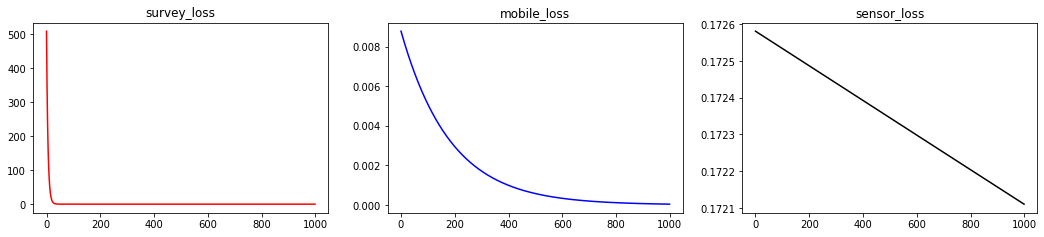

In [7]:
Loss = gradient_descent_algorithm(est_alpha, est_gamma, est_v, survey_val, ozone_od_inc_mat, mobile_val, sensor_mat, sensor_val)
end = timeit.default_timer()
print('Computing Time: ', end - start)

# Plot loss functions
list_all = [Loss[0], Loss[1], Loss[2]]
c = ['r-', 'b-', 'k']
name_list = ['survey_loss', 'mobile_loss', 'sensor_loss']
plt.figure(figsize=(18, 3.5))

for i in range(len(list_all)):
  subplot = plt.subplot(1, len(list_all), i+1)
  subplot.plot(list_all[i], c[i])
  plt.title(name_list[i])